In [14]:
!pip -q install imbalanced-learn==0.8.0
!curl 'https://media.githubusercontent.com/media/flomch/bitcoin-heist-detection/main/bitcoin-heist.csv' > bitcoin-heist.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 43.7M  100 43.7M    0     0  57.6M      0 --:--:-- --:--:-- --:--:-- 57.6M


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from scipy.stats import mode


from   sklearn.model_selection    import *
from   sklearn.compose            import *
from   sklearn.ensemble           import RandomForestClassifier, ExtraTreesClassifier, IsolationForest
from   sklearn.experimental       import enable_iterative_imputer
from   sklearn.impute             import *
from   sklearn.linear_model       import *
from   sklearn.metrics            import *  
from   sklearn.pipeline           import Pipeline
from   sklearn.preprocessing      import *
from   sklearn.tree               import DecisionTreeClassifier, ExtraTreeClassifier
from   sklearn.svm                import SVC
from   sklearn.neighbors          import *
from   sklearn.inspection         import permutation_importance
from   sklearn.base               import BaseEstimator, TransformerMixin


# from rfpimp import *
import imblearn.pipeline as imbPipe
import imblearn
from imblearn.over_sampling import *
from imblearn.under_sampling import *


# turn off convergence warning
import warnings
with warnings.catch_warnings():
    warnings.filterwarnings('ignore', 'Solver terminated early.*')

pd.options.display.float_format = '{:.5f}'.format
%config InlineBackend.figure_format='retina'


/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [16]:
df = pd.read_csv('bitcoin-heist.csv')

X = df.drop(columns='label')
y = df.label

In [17]:
print(f'Total rows: {len(df)}.   Total columns: {len(df.columns)})')
print()
print('Target variable distribution')
print(y.value_counts(dropna=False))

Total rows: 583339.   Total columns: 10)

Target variable distribution
0    575056
1      8283
Name: label, dtype: int64


# Preprocessing

In [18]:
# removed address from features, since they are randomly assigned ids
useful_features = ['year','day','length','weight','count', 'looped', 'neighbors', 'income']

# features with highly right skewed distribution will be log transformed
log_features = ['weight','count', 'looped', 'neighbors', 'income']

# create X preprocessing pipeline
# there are no categorical vars, hence only one numeric imputer is needed

prep = ColumnTransformer([# imputate missing numeric data (if any)
                          ('imputer', SimpleImputer(strategy='median', add_indicator=True), useful_features),
                          
                          # log transform
                          ('log_transform', FunctionTransformer(lambda x: np.log(x+1)), log_features),  
                          
                          # standardize models for faster/more accurate fitting
                          ('standard', StandardScaler(), useful_features)]
                           
                          # drop any columns not treated above. 
                          ,remainder='drop'
                          )

# Model Search
## Step 1: Random Grid Search
In this step, I will execute random grid search on hyperparameters for Logistic Regression, Random Forest, and Extra Tree Forest. This will provide a rough sense of good models to further fine-tune.

## Step 2: Parameter Grid Search
The top 5 models from step 1 will be exhaustively searched against an upsampling technique, SMOTE, and a downsampling technique, Random Under Sampler, using parameter grid search. 

**Question: Why not also search for sampling techniques in step 1?**   
Resampling techniques, especially SMOTE, is time-costly. Random grid search will not finish running in a day if I added resampling to each of the 20 iterations (for a total of 100 fits)!   
    
      
-----

# Evaluation Metrics
The classic quartet: F1, ROC/AUC, precision, recall
* Recall: of the true ransomeware accounts, how many did the model identify.
* Precision: of the ransomware accounts the model has identified, how many were actually true.
* This task requires a fine balance between precision and recall. On the one hand, we don't want to falsely predict many white accounts as ransomeware, but on the other hand, we don't want to miss too many ransomware accounts.
* Hence, on top of examining precision/recall individually, F1 and ROC/AUC provide a more balanced overview of the model's performance. 




In [19]:
# split dataframe
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=1, stratify=y)

In [20]:
# create dummy estimator to allow random search on a few models

class DummyTransformer():
    def fit_resample(self): pass
    
class DummyEstimator(BaseEstimator):
    def fit(self): pass
    def score(self): pass

## Step 1: Random Grid Search

In [ ]:
pipe = imbPipe.Pipeline(steps=[('prep', prep),
                               ('estimator', DummyEstimator())])

# create search space on logistic regression, ensemblers,
search_space = [
                # Logistic Regression hyperparms
                dict(estimator=[LogisticRegression(warm_start=True, n_jobs=-1)],
                     estimator__C=[0.01, 0.5, 1, 2, 3, 10, 100] # regularization strength, smaller is stronger
                    ),
                
                # Random Forest hyperparms
                dict(estimator=[RandomForestClassifier(n_jobs=-1)],
                     estimator__n_estimators=[30, 50, 100],  # affects validation variance
                     
                     # imbalanced dataset, weights used to bring out minority case more
                     estimator__class_weight=['balanced', 'balanced_subsample', 
                                              {0:1,1:20}, {0:1,1:35}, {0:1,1:70}],
                     
                     # hyperparm below all used for balancing between overfitting and accuracy
                     estimator__max_features=['sqrt','auto', 2, 4, 6, 8],  
                     estimator__max_depth=[None, 5, 10, 15, 20],
                     estimator__min_samples_split=[2, 5, 10],
                     estimator__min_samples_leaf=[1,3,5,7],
                     estimator__bootstrap=[True, False]
                    ),
                
                dict(
                     estimator=[ExtraTreesClassifier(n_jobs=-1)],
                     # imbalanced dataset, weights used to bring out minority case more
                     estimator__class_weight=['balanced', 'balanced_subsample', {0:1,1:20}, {0:1,1:35}, {0:1,1:70}],

                     # hyperparm below all used for balancing between overfitting and accuracy
                     estimator__n_estimators=[30, 50, 100],
                     estimator__max_features=['sqrt','auto', 2, 4, 6, 8],
                     estimator__max_depth=[None, 5, 10, 15, 20],
                     estimator__min_samples_split=[2, 5, 10],
                     estimator__min_samples_leaf=[1,3,5,7],
                     estimator__bootstrap=[True, False]
                     )]

# evaluation metrics
scoring =['recall', 'precision', 'f1', 'roc_auc']

# random grid search across models and their hyperparms
clf_rand = RandomizedSearchCV(estimator=pipe, 
                              param_distributions=search_space, 
                              n_iter=20,
                              scoring=scoring,
                              cv=5,
                              verbose=5,
                              refit=False,
                              n_jobs=-1,
                              random_state=0
                              )
clf_rand.fit(X_train, y_train) 
print('RANDOM GRID SEARCH COMPLETE')

Fitting 5 folds for each of 20 candidates, totalling 100 fits
RANDOM SEARCH COMPLETE


In [ ]:
# extract cv results into dataframe
cv_results = pd.DataFrame(clf_rand.cv_results_)


# Chose candidate models for further tuning
Models were evaluated based on their mean ranking across the four metrics (F1, precision, recall, and ROC/AUC). Top 5 models with highest mean rank were selected as candidates.

In [ ]:
# get models' mean ranking across all 4 evaluation metrics
cv_results['rank_mean'] = cv_results[['rank_test_recall','rank_test_precision', 'rank_test_f1', 'rank_test_roc_auc']].mean(axis=1)
cv_results['rank_mode'] = cv_results[['rank_test_recall','rank_test_precision', 'rank_test_f1', 'rank_test_roc_auc']].apply(lambda x: mode(x), axis=1)

cols = ['param_estimator','params', 'rank_mean', 'rank_mode', 'mean_test_recall','mean_test_precision', 'mean_test_f1', 'mean_test_roc_auc',
        'rank_test_recall','rank_test_precision', 'rank_test_f1', 'rank_test_roc_auc']

print('Top 5 models from random grid search')
cv_results[cols].sort_values('rank_mean').head(5)


,param_estimator,params,rank_mean,rank_mode,mean_test_recall,mean_test_precision,mean_test_f1,mean_test_roc_auc,rank_test_recall,rank_test_precision,rank_test_f1,rank_test_roc_auc
11,RandomForestClassifier(n_jobs=-1),"{'estimator__n_estimators': 50, 'estimator__mi...",6.00000,"([5], [2])",0.65945,0.22329,0.33341,0.94235,13,5,5,1
19,RandomForestClassifier(n_jobs=-1),"{'estimator__n_estimators': 100, 'estimator__m...",7.00000,"([2], [1])",0.44769,0.32663,0.37760,0.93214,17,2,3,6
5,RandomForestClassifier(n_jobs=-1),"{'estimator__n_estimators': 30, 'estimator__mi...",7.00000,"([2], [1])",0.52990,0.31302,0.39354,0.93020,15,4,2,7
2,ExtraTreesClassifier(n_jobs=-1),"{'estimator__n_estimators': 30, 'estimator__mi...",7.25000,"([3], [1])",0.77106,0.11173,0.19515,0.93560,7,10,9,3
10,RandomForestClassifier(n_jobs=-1),"{'estimator__n_estimators': 50, 'estimator__mi...",7.25000,"([8], [2])",0.70414,0.15695,0.25663,0.93726,11,8,8,2


In [ ]:
candidate_models = cv_results[cols].sort_values('rank_mean')['params'].head(5)

## Step 2: Parameter Grid Search
Sampling techniques: SMOTE, RandomUnderSampler

In [ ]:
pipe = imbPipe.Pipeline(steps=[('prep', prep),
                               ('sampling', DummyTransformer()),
                               ('estimator', DummyEstimator())])

# test one oversampler and one undersampler
sampling = [RandomUnderSampler(random_state=0), SMOTE(random_state=0)]


# create search space on sampling techniques for candidate models
search_space = []

for model in candidate_models:
  
  m_search_space = {}

  # get model type
  m = model.pop('estimator')
  
  # delete bootstrap from hyperparam, so model defaults to bootstrapping
  if not model.get('estimator__bootstrap', None):
    model.pop('estimator__bootstrap')
  
  # delete class balance, as that will be resolved by sampling
  if not model.get('estimator__bootstrap', None):
    model.pop('estimator__class_weight')
  
  # make existing into list for grid search
  hps = {}
  for key, val in model.items():
    hp = key.replace('estimator__','')
    hps[hp] = val  
  
  m.set_params(**hps)
  
  m_search_space['sampling'] = sampling
  m_search_space['estimator'] = [m]

  search_space.append(m_search_space)


# evaluation metrics
scoring =['recall', 'precision', 'f1', 'roc_auc']

# random grid search across models and their hyperparms
grid_cv = GridSearchCV(estimator=pipe, 
                       param_grid=search_space, 
                       scoring=scoring,
                       cv=5,
                       verbose=2,
                       refit=False
                      )

grid_cv.fit(X_train, y_train) 
print('PARAM GRID SEARCH COMPLETE')

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END estimator=RandomForestClassifier(max_depth=15, max_features=8, min_samples_leaf=3,
                       n_estimators=50, n_jobs=-1), sampling=RandomUnderSampler(random_state=0); total time=   4.5s
[CV] END estimator=RandomForestClassifier(max_depth=15, max_features=8, min_samples_leaf=3,
                       n_estimators=50, n_jobs=-1), sampling=RandomUnderSampler(random_state=0); total time=   3.2s
[CV] END estimator=RandomForestClassifier(max_depth=15, max_features=8, min_samples_leaf=3,
                       n_estimators=50, n_jobs=-1), sampling=RandomUnderSampler(random_state=0); total time=   3.2s
[CV] END estimator=RandomForestClassifier(max_depth=15, max_features=8, min_samples_leaf=3,
                       n_estimators=50, n_jobs=-1), sampling=RandomUnderSampler(random_state=0); total time=   3.2s
[CV] END estimator=RandomForestClassifier(max_depth=15, max_features=8, min_samples_leaf=3,
               

In [ ]:
# get models' mean ranking across all 4 evaluation metrics
grid = pd.DataFrame(grid_cv.cv_results_)

# calcualte mean ranking across scores for each model
grid['rank_mean'] = grid[['rank_test_recall',
                          'rank_test_precision', 
                          'rank_test_f1', 
                          'rank_test_roc_auc']].mean(axis=1)

## Plot cross-validation metrics across candidate models

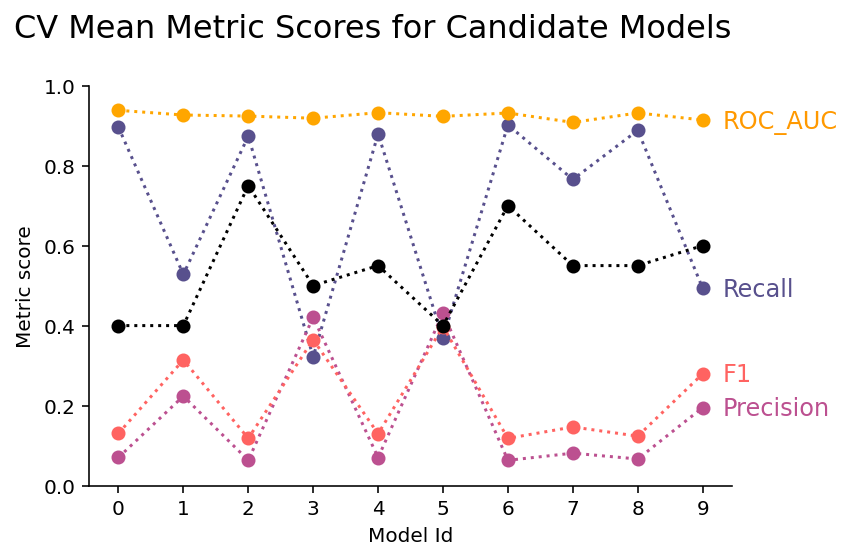

In [9]:
# hide the right and top spines
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

plt.plot(grid.index, grid.mean_test_recall,'o:',  color='#58508d', )
plt.plot(grid.index, grid.mean_test_precision, 'o:', color='#bc5090')
plt.plot(grid.index, grid.mean_test_f1, 'o:', color='#ff6361')
plt.plot(grid.index, grid.mean_test_roc_auc, 'o:', color='#ffa600')

plt.xlabel('Model Id')
plt.ylabel('Metric score')
plt.xticks(grid.index.values)
plt.yticks(np.linspace(0,1,6))

# label each line with right metric name
label_name = ['Recall', 'Precision','F1','ROC_AUC']
color = ['#58508d','#bc5090','#ff6361','#ff9900']
for i, metric in enumerate(['mean_test_recall', 'mean_test_precision','mean_test_f1','mean_test_roc_auc']):
  plt.text(9.3, grid[grid.index==9][metric]-0.02, label_name[i], color=color[i], fontsize=12)

plt.title('CV Mean Metric Scores for Candidate Models\n',fontsize=16, loc='right')
plt.tight_layout()
plt.show()


### Model 5 had the best overall ranking. 
The old rivalry between precision and recall are exemplified in this chart. You get very good recall in exchange for terrible precision, or you get mediocre recall for not-so-terrible-but-not-so-great precision. Overall, this suggests considerable overlap between the distributions of white and ransomware account.

In [ ]:
print('We have a winner 🎉')
grid.sort_values('rank_mean').head(1)['params'].values[0]

We have a winner 🎉


array([{'estimator': RandomForestClassifier(max_depth=15, max_features=8, min_samples_leaf=3,
                       n_estimators=50, n_jobs=-1), 'sampling': RandomUnderSampler(random_state=0)}],
      dtype=object)

### Note
Final model in section below may be different from what's printed above. This is to be expected from random grip search.

# Final Model
### RandomForestClassifier(min_samples_leaf=7, n_estimators=30)
7 minimum samples at leaf node is a good measure to prevent overfitting, while limiting trees to 30 suggests there is a diminishing return in accuracy to train more trees beyond 30.





In [142]:
sampling_method = RandomUnderSampler()

model = RandomForestClassifier(min_samples_leaf=7, n_estimators=30, n_jobs=-1)

pipe = imbPipe.Pipeline(steps=[('prep', prep),
                               ('sampling', sampling_method),
                               ('estimator', model)
                               ])

pipe.fit(X_train, y_train)

# evaluate model against test
pred = pipe.predict(X_test)
pred_prob = pipe.predict_proba(X_test)[:, 1]

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


# Evaluate model against test dataset

In [171]:
cf = confusion_matrix(y_test, pred)
f1 = f1_score(y_test, pred)
recall = recall_score(y_test, pred)
precision = precision_score(y_test, pred)
auc = roc_auc_score(y_test, pred_prob)

print('Confusion matrix')
display(pd.DataFrame(cf, columns=[0,1]))
print()
print(f'{"Recall:":<12} {recall:>5.2f}',
      f'{"Precision:":<12} {precision:>5.2f}',
      f'{"F1:":<12} {f1:>5.2f}',
      f'{"ROC/AUC:":<12} {auc:>5.2f}',
      sep='\n')

Confusion matrix


,0,1
0,96135,18876
1,195,1462



Recall:       0.88
Precision:    0.07
F1:           0.13
ROC/AUC:      0.94


# Feature importance on the test dataset

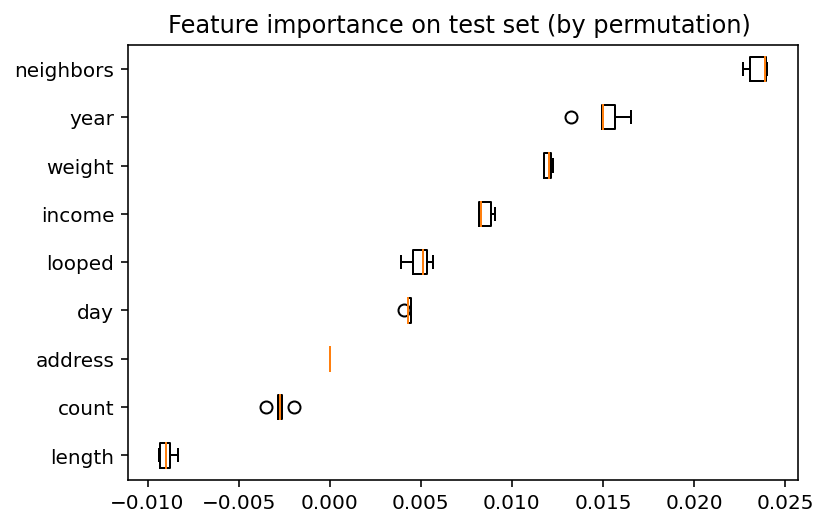

In [143]:
result = permutation_importance(pipe, X_test, y_test, n_jobs=-1)

sort_idx = result.importances_mean.argsort()

fig, ax = plt.subplots()
ax.boxplot(result.importances[sort_idx].T,
           vert=False, labels=X_test.columns[sort_idx])
ax.set_title("Feature importance on test set (by permutation) ")
plt.show()

# Summary 
In highly unregulated and open money markets like Bitcoin, transaction details are often publically available. The large data repertoire enables automated crime monitoring processes by leveraging machine learning. Although my model didn't achieve very desirable results, it gave a glimpse into the law enforcement capabilities of AI.

My final model was very good at identifying ransomeware accounts, but it came at the cost of mislabelling many white accounts as ransomeware. 

It was surprising to see that despite decent precision scores during cross validation (0.4), the model performed significantly worser in the test set (precision score = 0.07). However, other metric scores conformed to patterns found in the validation step. 


## Possible next steps:
* Attempt learning models with the entire dataset. Only 20% of the actual dataset was used for this project due to computation limitations.
* Scrap more bitcoin-related data to provide new information to the model.

